In [3]:
from fastai.text.all import *
import pandas as pd

## Introduction

The aim of this project is to classify Dell Technical Support emails into 'software' or 'hardware' catagories. A total of 1324 emails where taken via Dell in-house case scraping tool. 662 emails labelled as Software ('sw') and 662 labbeled as Hardware related ('hw') based on the researcher's domain knowledge. The dataset was saved as a CSV file, with each row being one email.

This notebook begins with usinga  pretrained language model (Wikitext103) which understands teh stucture of language, and use it to read and predict emails as being 'sw' or 'hw'.

The emails themselves are tokenized (seperate sentences into words) and using special 'tokens' we can ensure that each example per-batch is of the same size (padding samll emails with nonsense reserved tokens, 'xxunk') and the words are numericalised to form a vocabulary (starting with the most common occuring word). 

To improve perforance we then train are own language model(based on LSTM architecture) on Dell sepcific vocaburary. The model is tasked with predicting the next occuring word.

Finally we train our new language model to again classify the images, and gradually unfreeze each layer to improve performance further.

Resources:
https://www.kaggle.com/hortonhearsafoo/fast-ai-v3-lesson-3-imdb

https://docs.fast.ai/tutorial.text#Train-a-text-classifier-from-a-pretrained-model

In [ ]:
# path = '/home/cian/Downloads/fastbook-master/my_Project' # Dell_Dataset_Final.tar.xz
# or ?
# path = '/home/cian/Downloads/Dell_Dataset_Final'

In [4]:
path = '/home/cian/Downloads/fastbook-master/my_Project/'

## Dataset

In [5]:
# import CSV file containing the dataset

df = pd.read_csv('Dataset_CSV.csv')

In [6]:
df.head(20)

,label,text
0,s,"Hi Technical support, We had an issue with the active controller today where emails as i will be the point of contact for this. Thanks."
1,s,I can't open web console
2,s,I want update Dell blade server M910 Bios and iDRAC Firmware
3,s,"iDRAC card on this server appears to be non-functional. New one has been ordered but I am unable to locate the Dell iDRAC Enterprise License that needs to be loaded up to it, so they the card will offer iDRAC functions. I am requesting assistance locating that file."
4,s,"Our network switch has crashed and needs its software to be re-installed. However, we have no copys of the software - OS10"
5,s,Please provide iDRAC Enterprise license for PowerEdge M620 with after MB replacement.
6,s,"System crashed, purple screen of death. Please assist with troubleshooting root cause."
7,s,"Team, we have installed ESXi6.5U3 and need help for NVIDIA supported drives."
8,h,Two drives in the array are showing solid amber lights but otherwise appear to be functioning correctly. Can't get the GUI console to work. Appears that the software is too old to run on the version of Windows Server 2008R2. Trying to find
9,h,VMWare showed a PSOD. Looks like a RAM Module died. TSR is attached to the ticket.


In [7]:
df['text'][7]

'   Team, we have installed ESXi6.5U3 and need help for NVIDIA supported drives. '

## TextDataLoader

we load the dataset in, sepcifying teh label and text columns. This TextDataLoader will also transform are email examples and apply tokenisation and numericalisation.

In [9]:
dls = TextDataLoaders.from_csv(path=path, csv_fname='Dataset_CSV.csv', text_col='text', label_col='label')
dls.show_batch(max_n=3)

/home/cian/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,xxbos xxmaj failed xxmaj disk in xxmaj slot 18 . xxmaj enclosure xxmaj device xxup i d : 64 xxmaj slot xxmaj number : 18 xxmaj device xxmaj i d : 18 xxmaj xxunk xxmaj number : 3 xxmaj media xxmaj error xxmaj count : 0 xxmaj other xxmaj error xxmaj count : 4 xxmaj predictive xxmaj failure xxmaj count : 0 xxmaj last xxmaj predictive xxmaj failure xxmaj event xxmaj xxunk xxmaj number : 0 xxup xxunk xxmaj type : xxup sas xxmaj xxunk xxmaj size : xxunk xxup tb [ xxunk xxmaj sectors ] xxmaj non xxmaj xxunk xxmaj size : xxunk xxup tb [ xxunk xxmaj sectors ] xxmaj xxunk xxmaj size : xxunk xxup tb [ xxunk xxrep 5 0 xxmaj sectors ] xxmaj firmware state : xxmaj failed xxup sas xxmaj xxunk ) : xxunk xxrep 3 0 xxunk xxup sas xxmaj xxunk ) :,h
1,"xxbos xxmaj i 've got two servers where i ca n't xxunk idrac settings from xxunk 3.2.1 . xxmaj it works for xxunk other servers ( xxunk 8 & 9 ) , but these xxunk . i get the xxup xxunk error . xxmaj the description ( in the error , and from https : / / xxrep 3 w .dell.com / support / xxunk / us / en / 04 / dell - xxunk - xxunk - xxunk / xxunk / lc - event - xxunk = xxunk - xxunk - xxunk = en - us ) does n't really help me . xxmaj how do still fails . xxmaj attached are xxup tsr from both servers and the deployment template xxunk from xxup xxunk . xxmaj it should just set idrac xxunk and xxunk and xxmaj active xxmaj directory settings . xxmaj what s xxunk the job ?",s
2,"xxbos xxmaj hi xxmaj xxunk , xxmaj regarding the correctable memory errors we have been receiving on xxmaj dell xxmaj servers . xxmaj these are under investigation between xxmaj dell and vmware . xxmaj during this investigation , we require the following steps for any new correctable memory errors that xxunk : xxmaj create a xxup tsr report xxunk https : / / xxrep 3 w .dell.com / support / article / ca / en / xxunk / xxunk / export - a - supportassist - collection - and - perc - log - via - xxunk = en . xxmaj swap the xxup dimm between correctable memory error issue and the case number to : xxunk xxunk xxunk xxunk ; xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk . xxmaj xxunk xxmaj xxunk xxrep 3 i . xxmaj xxunk xxmaj xxunk xxunk . xxmaj xxunk xxunk",h


We can see that the library automatically processed all the texts to split then in tokens, adding some special tokens like:

- xxbos to indicate the beginning of a text
- xxmaj to indicate the next word was capitalized

Next we define a Learner suitable for text classification:



## 1st Classification

In [11]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)



We use the AWD LSTM architecture, drop_mult is a parameter that controls the magnitude of all dropouts in that model, and we use accuracy to track down how well we are doing. We can then fine-tune our pretrained model:

In [12]:
learn.fine_tune(4, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.619599,0.576112,0.700758,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.459338,0.396279,0.840909,00:04
1,0.397563,0.361615,0.856061,00:04
2,0.341723,0.308726,0.886364,00:04
3,0.291458,0.297237,0.893939,00:04


Will test how the model performing with the classification using the show_results method:

In [13]:
learn.show_results()


,text,category,category_
0,"xxbos xxmaj noticed that vmware has a new xxmaj dell vmware 6.5 image on this page ; https : / / xxunk / group / vmware / xxunk = oem - xxunk xxmaj but we did n't find any information about which systems were compatible . xxmaj is it compatible with our servers ? xxmaj the image is n't visible here , where we usually xxunk for new vmware xxunk ; https : / / xxrep 3 w xxunk / support / home / us / en / 04 / product - support / servicetag / xxunk / drivers . xxmaj xxunk also whether our servers can be updated using normal vmware xxmaj update xxmaj manager updates ? xxmaj we have only used xxmaj dell xxunk to xxunk problems with our xxup vrtx systems , and an external scv3020 storage which they are connected to using xxup sas cards .",s,s
1,xxbos i receive an alert in xxmaj prism xxmaj central on all 3 xxmaj prism central nodes that the memory has a high usage : xxup cvm or xxup pc xxup vm xxup ram xxmaj usage xxmaj high xxmaj prism xxmaj central xxup vm xxmaj system xxmaj indicator xxmaj critical - - 15 - 11 - 19 xxunk xxmaj prism xxmaj central xxup cvm or xxup pc xxup vm xxup ram xxmaj usage xxmaj high xxmaj prism xxmaj central xxup vm xxmaj system xxmaj indicator xxmaj critical - - 15 - 11 - 19 xxunk xxmaj prism xxmaj central xxup cvm or xxup pc xxup vm xxup ram xxmaj usage xxmaj high xxmaj prism xxmaj central xxup vm xxmaj system xxmaj indicator xxmaj critical - - 15 - 11 - 19 xxunk xxmaj prism xxmaj central xxmaj please escalate to xxmaj nutanix engineer to xxunk,s,s
2,"xxbos xxmaj defective xxup ndc . xxmaj this is the third time i have opened a case for this server in which i signal the faulty xxup ndc . i xxunk he is xxunk this time . xxmaj the xxup ndc module it 's not detected . xxmaj see the attached xxup tsr logs xxunk . xxmaj we have updated all the firmware , but the situation has not changed . xxmaj this is the target component : xxunk : xxmaj broadcom xxunk xxmaj dual xxmaj port xxunk xxup xxunk - t & xxunk xxmaj dual xxmaj port xxunk xxup xxunk - t , xxunk - xxmaj code : xxup xxunk .",h,h
3,"xxbos i am trying to get xxmaj quick xxmaj boot running on my 3 xxmaj dell poweredge xxup r630 servers . xxmaj when i try to run the compatibility check , i get : / xxunk / xxunk / vmware / xxunk / xxunk / xxunk xxunk is not compatible with xxunk drivers . xxmaj compatibility check failed : xxunk one or more on this machine ) xxmaj when i ran the module check ( esxcli system module list ) i saw xxunk listed as a module , and is probably the problem . xxmaj how do i get xxmaj quick xxmaj boot running ?",s,s
4,"xxbos xxup hba with errors xxmaj the xxmaj host unit xxmaj server - xxup xxunk is not xxunk light . xxmaj the xxmaj xxunk xxmaj port switch - xxrep 3 xxunk xxunk fc3 / 13 is not xxunk light . i tested the fiber cable and the loss xxunk across the xxmaj path was xxunk xxunk . xxmaj the cable tests good with the loss level i xxunk . i swapped out the switch - xxrep 3 xxunk xxunk fc3 / 13 xxup sfp , it still did not xxunk light , so i placed the original xxup sfp back into fc3 / 13 .",s,h
5,xxbos xxmaj failed 32 gb memory xxup dimm . xxmaj faulty memory xxup dimm in xxup xxunk server - multi - bit memory errors . xxup dimm was moved to another xxup dimm slot in the same server several days ago but soon began to log further errors . xxmaj the xxup dimm has also been tested in another identical model of server but soon xxunk to log errors there too . xxmaj known - good xxup dimm has now been installed and this works perfectly . xxmaj all host firmwares are at current revisions . xxmaj please ship replacement xxup dimm ( part,h,h
6,"xxbos xxmaj attempting to update drivers using the xxmaj dell xxmaj update xxmaj utility and the server crashes . xxmaj on restart there are xxunk for errors xxup xxunk and xxup xxunk . xxmaj xxunk the xxup lc logs and found errors on xxmaj bus 0 xxmaj dev 29 xxmaj xxunk 2 and xxmaj bus 4 xxmaj dev 0 xxmaj xxunk 0 xxmaj reviewing those device , they are the xxup pci xxma

Before Fine Tune Language Model


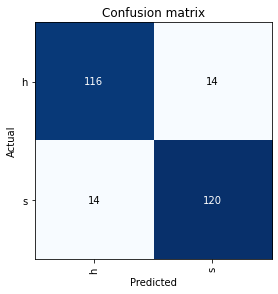

In [14]:
# 1st classification perormance confussion matrix

    
    
interp = ClassificationInterpretation.from_learner(learn)
print("Before Fine Tune Language Model")
interp.plot_confusion_matrix()

## Unseen data:

And we can predict on new texts (unseen data)

In [15]:
learn.predict("please help me update my server software")


('s', tensor(1), tensor([0.0011, 0.9989]))

In [16]:
learn.predict("I am having issues after software update, I believe it is a hardware issues and need a DIMM replaced")


('s', tensor(1), tensor([0.0308, 0.9692]))

Above we can see an emphasis on the 'software' keyword, mis-classifying it wih 96% confidence.

In [17]:
learn.predict("please help this is not a software issue this is a hardware problem")


('s', tensor(1), tensor([0.1353, 0.8647]))

We can also use the data block API to get our data in a DataLoaders

- the types used, through an argument called blocks: here we have images and categories, so we pass TextBlock and CategoryBlock. To inform the library our texts are files in a folder, we use the from_folder class method.
- how to get the raw items, here our function get_text_files.
- how to label those items, here with the parent folder.
- how to split those items, here with the grandparent folder.

## Fine-tuning a language model on Dell vocab

Using a pretrained language model, trained on Wikipedia. This lWikiText103 model has the task of predicting the next word, after reading words before it. 

Then we fine_tune this language model to a Dell email classifier (hardware or software)

Wikipedia english is different to the language used in Dell emails (specific Dell terminology ect.). So we fine-tune our pretrained language model to the Dell corpus and then use that as the base for our classifier.


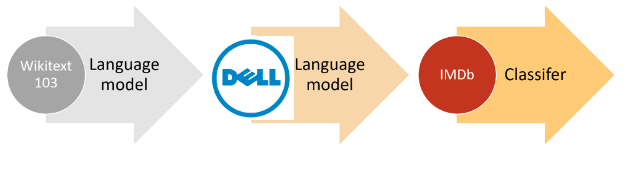


We can get our texts (DEll emails) in a DataLoaders suitable for language modeling:





In [18]:
# dls = TextDataLoaders.from_csv(path=path, csv_fname='Dataset_CSV.csv', text_col='text', label_col='label')

dell_lm = TextDataLoaders.from_csv(path=path, csv_fname='Dataset_CSV.csv', text_col='text', label_col='label', is_lm=True, valid_pct=0.1)


/home/cian/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


- valid_pct=0.1, we tell it to get a random 10% of those reviews for the validation set.
- is_lm = True indicates if we want to use texts for language modeling

Remember, to train the Dell language model (dell_lm) we request it to guess the next word in the sentence. Below we can see the targets have all shifted one word to the right.



In [19]:
dell_lm.show_batch(max_n=5)


,text,text_
0,"xxbos error - the storage xxup xxunk xxmaj power cable is not connected , or is improperly connected . we have already replaced the backplane and cable in past still we received the 2 alert in xxunk past xxunk / xxunk xxmaj please check and let me know the xxup poa xxbos latency is showing high number as per the attached xxunk . also i need to identify for up to how","error - the storage xxup xxunk xxmaj power cable is not connected , or is improperly connected . we have already replaced the backplane and cable in past still we received the 2 alert in xxunk past xxunk / xxunk xxmaj please check and let me know the xxup poa xxbos latency is showing high number as per the attached xxunk . also i need to identify for up to how many"
1,"the following error : xxbos xxmaj server xxmaj xxunk xxunk upon powering xxmaj xxunk of xxmaj box ) . xxup xxunk xxunk xxup xxunk xxmaj xxunk ( xxmaj xxunk xxmaj xxunk ( server xxup xxunk ( xxunk - xxunk ) xxmaj diagnostic : xxmaj see troubleshooting steps below xxmaj diagnostic xxmaj test : xxmaj yes , xxmaj diagnostic xxunk & xxmaj message : xxup see xxup attached xxup logs xxmaj validation xxmaj","following error : xxbos xxmaj server xxmaj xxunk xxunk upon powering xxmaj xxunk of xxmaj box ) . xxup xxunk xxunk xxup xxunk xxmaj xxunk ( xxmaj xxunk xxmaj xxunk ( server xxup xxunk ( xxunk - xxunk ) xxmaj diagnostic : xxmaj see troubleshooting steps below xxmaj diagnostic xxmaj test : xxmaj yes , xxmaj diagnostic xxunk & xxmaj message : xxup see xxup attached xxup logs xxmaj validation xxmaj code"
2,"the boot , at no point does the idrac get an xxup ip . xxbos xxmaj the server was ordered with idrac enterprise . xxmaj somehow it xxunk its license file and now is xxmaj xxunk . xxbos xxmaj we are facing issues with installing the ism xxunk on esx host . xxbos xxmaj multi - bit memory errors detected . xxmaj multi - bit memory errors detected on a memory device","boot , at no point does the idrac get an xxup ip . xxbos xxmaj the server was ordered with idrac enterprise . xxmaj somehow it xxunk its license file and now is xxmaj xxunk . xxbos xxmaj we are facing issues with installing the ism xxunk on esx host . xxbos xxmaj multi - bit memory errors detected . xxmaj multi - bit memory errors detected on a memory device at"
3,"was replaced with one of a different server . xxmaj now the disk was working again . xxbos xxmaj kindly assist with the idrac enterprise license , the idrac does not respond on the host and seems to have a xxunk license whether we have an enterprise license on our hosts racadm license view xxunk xxmaj status = xxmaj the license has expired . xxmaj device = xxunk xxmaj device xxmaj description","replaced with one of a different server . xxmaj now the disk was working again . xxbos xxmaj kindly assist with the idrac enterprise license , the idrac does not respond on the host and seems to have a xxunk license whether we have an enterprise license on our hosts racadm license view xxunk xxmaj status = xxmaj the license has expired . xxmaj device = xxunk xxmaj device xxmaj description ="
4,. i have updated the firmware which did not correct the issue . i tried reseating the adapter and riser it still persisted in not functioning .. xxbos xxmaj we are experiencing an issue with one of the dimm 's in slot xxup b4 on our poweredge xxup r740 xxup xxunk . xxmaj please be advised the motherboard was swapped out on this device this morning by a xxmaj dell xxmaj engineer,i have updated the firmware which did not correct the issue . i tried reseating the adapter and riser it still persisted in not functioning .. xxbos xxmaj we are experiencing an issue with one of the dimm 's in slot xxup b4 on our poweredge xxup r740 xxup xxunk . xxmaj please be advised the motherboard was swapped out on this device this morning by a xxmaj dell xxmaj engineer in


Then using the AWD_LSTM architecture, also used in the previous Learner. We use accuracy and perplexity as metrics (the later is the exponential of the loss) and we set a default weight decay of 0.1. to_fp16 puts the Learner in mixed precision, which is going to help speed up training on GPUs that have Tensor Cores.

In [20]:
learn = language_model_learner(dell_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

## Freezing
By default, a pretrained Learner is in a frozen state, meaning that only the head of the model will train while the body stays frozen. We show you what is behind the fine_tune method here and use a fit_one_cycle method to fit the model

We train with discriminative learning rates and gradual unfreezing. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.





In [21]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.241202,4.738733,0.219510,114.289337,00:01


## Saving Epochs

It will create a file in learn.path/models/ named "1epoch.pth". If you want to load your model on another machine after creating your Learner the same way, or resume training later, you can load the content of this file with:

learn = learn.load('1epoch')

Path('/home/cian/Downloads/fastbook-master/my_Project/models/1epoch.pth')



In [22]:
learn.save('1epoch')


Path('/home/cian/Downloads/fastbook-master/my_Project/models/1epoch.pth')

## Unfreezing

We can them fine-tune the model after unfreezing:



In [23]:
learn.unfreeze()
learn.fit_one_cycle(15, 1e-3)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.745291,4.496336,0.224501,89.687912,00:02
1,4.610158,4.213381,0.244249,67.584648,00:02
2,4.467466,4.039433,0.260308,56.794106,00:02
3,4.324167,3.872668,0.279731,48.070480,00:02
4,4.184862,3.794966,0.274740,44.476711,00:02
5,4.054781,3.738801,0.288303,42.047535,00:02
6,3.921369,3.692101,0.291124,40.129070,00:02
7,3.802547,3.673348,0.296875,39.383560,00:02
8,3.693645,3.656542,0.311089,38.727203,00:02
9,3.586087,3.640138,0.296658,38.097099,00:02


In [24]:
# save the ENCODER (arhitecture)

learn.save_encoder('finetuned')


The accuracy score is not expected to reach very high 

## Text Generation

We can use our language model to generate random customer emails: since it's trained to guess what the next word of the sentence is, we can use it to write new emails:

In [25]:
TEXT = "Hi, I need help with"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [26]:
print("\n".join(preds))


Hi , i need help with the support & support support to restore idrac Enterprise software to the idrac and the OS version in the process . Nutanix ME4024 has failed in Firmware . The firmware version on screen
Hi , i need help with the server Hi , i tried to update Firmware , but the issue followed the original firmware . But it 's not responding , I have tried to install Firmware , but i am


## 2nd Classification

First we gather our dataset again for text classification, we should now see an imporvemnt in performance 


In [27]:
dls_classification = TextDataLoaders.from_csv(path=path, csv_fname='Dataset_CSV.csv', text_col='text', label_col='label',  text_vocab=dell_lm.vocab)


/home/cian/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


We pass the Dell learned vocabulary (dell_lm.vocab) with text_vocab. Unsure if we need to pass valid='test'- name of the validation folder, which is "test" (and not the default "valid").

In [28]:
# train
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)


The difference is that before training it, we load the previous encoder (learn.save_encoder('finetuned'))






## Gradual UnFreezing

In [29]:
learn = learn.load_encoder('finetuned')


In [30]:
learn.fit_one_cycle(1, 2e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.414520,0.429870,0.833333,00:02


We can see that the first epoch, we see an accuracy of 72% compared to last time, one epoch got us 19%

We can pass -2 to freeze_to to freeze all except the last two parameter groups:

In [31]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.378313,0.320307,0.871212,00:02


Then we can unfreeze a bit more, and continue training and repeat



In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.241989,0.251427,0.901515,00:03


In [34]:
# now unfreeze entire model
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.185513,0.254597,0.901515,00:04
1,0.157917,0.256409,0.905303,00:04


In [35]:
learn.predict("please help this is not a software issue this is a hardware problem")


('s', tensor(1), tensor([0.1677, 0.8323]))

In [36]:
learn.show_results()


,text,category,category_
0,"xxbos xxmaj noticed that vmware has a new xxmaj dell vmware 6.5 image on this page ; https : / / xxunk / group / vmware / xxunk = oem - xxunk xxmaj but we did n't find any information about which systems were compatible . xxmaj is it compatible with our servers ? xxmaj the image is n't visible here , where we usually xxunk for new vmware xxunk ; https : / / xxrep 3 w xxunk / support / home / us / en / 04 / product - support / servicetag / xxunk / drivers . xxmaj xxunk also whether our servers can be updated using normal vmware xxmaj update xxmaj manager updates ? xxmaj we have only used xxmaj dell xxunk to xxunk problems with our xxup vrtx systems , and an external scv3020 storage which they are connected to using xxup sas cards .",s,s
1,xxbos i receive an alert in xxmaj prism xxmaj central on all 3 xxmaj prism central nodes that the memory has a high usage : xxup cvm or xxup pc xxup vm xxup ram xxmaj usage xxmaj high xxmaj prism xxmaj central xxup vm xxmaj system xxmaj indicator xxmaj critical - - 15 - 11 - 19 xxunk xxmaj prism xxmaj central xxup cvm or xxup pc xxup vm xxup ram xxmaj usage xxmaj high xxmaj prism xxmaj central xxup vm xxmaj system xxmaj indicator xxmaj critical - - 15 - 11 - 19 xxunk xxmaj prism xxmaj central xxup cvm or xxup pc xxup vm xxup ram xxmaj usage xxmaj high xxmaj prism xxmaj central xxup vm xxmaj system xxmaj indicator xxmaj critical - - 15 - 11 - 19 xxunk xxmaj prism xxmaj central xxmaj please escalate to xxmaj nutanix engineer to xxunk,s,s
2,"xxbos xxmaj defective xxup ndc . xxmaj this is the third time i have opened a case for this server in which i signal the faulty xxup ndc . i xxunk he is xxunk this time . xxmaj the xxup ndc module it 's not detected . xxmaj see the attached xxup tsr logs xxunk . xxmaj we have updated all the firmware , but the situation has not changed . xxmaj this is the target component : xxunk : xxmaj broadcom xxunk xxmaj dual xxmaj port xxunk xxup xxunk - t & xxunk xxmaj dual xxmaj port xxunk xxup xxunk - t , xxunk - xxmaj code : xxup xxunk .",h,h
3,"xxbos xxup hba with errors xxmaj the xxmaj host unit xxmaj server - xxup xxunk is not xxunk light . xxmaj the xxmaj xxunk xxmaj port switch - xxrep 3 xxunk xxunk fc3 / 13 is not xxunk light . i tested the fiber cable and the loss xxunk across the xxmaj path was xxunk xxunk . xxmaj the cable tests good with the loss level i xxunk . i swapped out the switch - xxrep 3 xxunk xxunk fc3 / 13 xxup sfp , it still did not xxunk light , so i placed the original xxup sfp back into fc3 / 13 .",s,h
4,"xxbos i am trying to get xxmaj quick xxmaj boot running on my 3 xxmaj dell poweredge xxup r630 servers . xxmaj when i try to run the compatibility check , i get : / xxunk / xxunk / vmware / xxunk / xxunk / xxunk xxunk is not compatible with xxunk drivers . xxmaj compatibility check failed : xxunk one or more on this machine ) xxmaj when i ran the module check ( esxcli system module list ) i saw xxunk listed as a module , and is probably the problem . xxmaj how do i get xxmaj quick xxmaj boot running ?",s,s
5,xxbos xxmaj failed 32 gb memory xxup dimm . xxmaj faulty memory xxup dimm in xxup xxunk server - multi - bit memory errors . xxup dimm was moved to another xxup dimm slot in the same server several days ago but soon began to log further errors . xxmaj the xxup dimm has also been tested in another identical model of server but soon xxunk to log errors there too . xxmaj known - good xxup dimm has now been installed and this works perfectly . xxmaj all host firmwares are at current revisions . xxmaj please ship replacement xxup dimm ( part,h,h
6,"xxbos xxmaj error at xxmaj memory . xxmaj after a node failure , the xxup lcc reported several errors , which were caused by faulty memory : xxup cpu 2 machine check error detected . xxmaj an xxup oem diagnostic event occurred . xxmaj multi - bit memory errors detected on a memory device at location xxup dimm_a5 . xxmaj the module was switched with a different module in 

## Confussion Matrix

With the fully trained model, based on Dell specific vocaburary we are able to classify 109 hw and 115 sw emails accuratly. With only a few false positives of 23 hw emails that weger actually sw, and 17 sw emails mistakenly classified as hw.

Mu assumption is these mis-classifed emails are easily misinterrurpretted examples, however still working on oulling the text examples that where misclassifed by the final model (40 emails in total)


In [37]:
interp = ClassificationInterpretation.from_learner(learn)


After Fine Tune Language Model


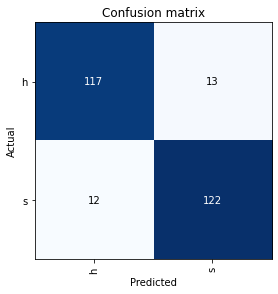

In [38]:
print("After Fine Tune Language Model")
interp.plot_confusion_matrix()
